In [3]:
import pandas as pd # 0.21.0
import numpy as np
from functools import reduce
from time import time

import os
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import scipy
from scipy import stats
import matplotlib.pyplot as plt

import quandl

In [4]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

### NOTE: 
1. Moving to predict open to close returns, want to avoid gap risk.

In [5]:
import talib as ta
ta.get_function_groups

<function talib.get_function_groups>

In [6]:
np.random.seed(100)
quandl.ApiConfig.api_key = "eFys5fhhsTNVrsJEcQ5y"

In [69]:
def get_features(ticker, start, end):
    try:
        df = quandl.get("WIKI/"+ticker, start_date=start, end_date=end)
    except Exception as e:
        print("Error in getting stock data: {}".format(e))

    # Handle look ahead-bias
    shifted_df = df.shift(1)
    #log_ret_df = get_close_to_close_log_returns(df['Adj. Close'])
    log_ret_df = get_open_to_close_log_returns(shifted_df[['Adj. Close','Adj. Open']])
    
    momentum_df = get_momentum_indicators(shifted_df)
    hist_vol_df = get_hist_vol_indicators(shifted_df)
    pattern_df = get_pattern_recognition_indicators(shifted_df)
    cycle_df = get_cycle_indicators(shifted_df)
    overlap_df = get_overlap_indicators(shifted_df)
    ohlc_df = get_ohlc_features(df)
    
    dfs = [shifted_df, log_ret_df, momentum_df, hist_vol_df, pattern_df, cycle_df, overlap_df, ohlc_df]
    df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs).dropna()
    return df_final

def get_close_to_close_log_returns(df):
    df_log =  pd.DataFrame(np.log(df/df.shift(1))).dropna()
    df_log = df_log.rename(index=str, columns={"Adj. Close": "log_ret"})
    return df_log

def get_open_to_close_log_returns(df):
    df['log_ret'] = np.log(df['Adj. Close']/df['Adj. Open'])
    del df['Adj. Close']
    del df['Adj. Open']
    
    return df

def get_momentum_indicators(df, days = [7,14,28, 56]):
    # http://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    momentum = dict()
    for t in days:
        momentum['adx_{}'.format(t)] = ta.ADX(high, low, close, timeperiod=t)
        momentum['adxr_{}'.format(t)] = ta.ADXR(high, low, close, timeperiod=t)
        momentum['aroondown_{}'.format(t)], momentum['aroonup_{}'.format(t)] = ta.AROON(high, low, timeperiod=t)
        momentum['aroon_{}'.format(t)] = ta.AROONOSC(high, low, timeperiod=t)
        momentum['rsi_{}'.format(t)] = ta.RSI(close, timeperiod=t)
        momentum['mom_{}'.format(t)] = ta.MOM(close, timeperiod=t)
        momentum['roc_{}'.format(t)] = ta.ROC(close, timeperiod=t)
        momentum['willr_{}'.format(t)] = ta.WILLR(high, low, close, timeperiod=t)
        momentum['trix_{}'.format(t)] = ta.TRIX(close, timeperiod=t)
        
        
    momentum['apo'] = ta.APO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['macd'], momentum['macdsignal'], momentum['macdhist'] = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    momentum['ppo'] = ta.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['slowk'], momentum['slowd'] = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    momentum['fastk'], momentum['fastd'] = ta.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    momentum['fastkrsi'], momentum['fastdrsi'] = ta.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    
    
    df = pd.DataFrame.from_dict(momentum)
    df = df.set_index(df_index)
    return df

def get_hist_vol_indicators(df, days = [7,14,28, 56]):
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    hist_vol = dict()
    for t in days:
        hist_vol['atr_{}'.format(t)] = ta.ATR(high, low, close, timeperiod=t)
        hist_vol['natr_{}'.format(t)] = ta.NATR(high, low, close, timeperiod=t)
        hist_vol['std_{}'.format(t)] = ta.STDDEV(close, timeperiod=t, nbdev=1)
        hist_vol['var_{}'.format(t)] = ta.VAR(close, timeperiod=t, nbdev=1)
        hist_vol['linreg_{}'.format(t)] = ta.LINEARREG(close, timeperiod=t)

        
    hist_vol['trange'] = ta.TRANGE(high, low, close)
    df = pd.DataFrame.from_dict(hist_vol)
    df = df.set_index(df_index)
    return df

def get_pattern_recognition_indicators(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    patterns = dict()
    patterns['CDL2CROWS'] = ta.CDL2CROWS(open, high, low, close)
    patterns['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(open, high, low, close)
    patterns['CDL3INSIDE'] = ta.CDL3INSIDE(open, high, low, close)
    patterns['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(open, high, low, close)
    patterns['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(open, high, low, close)
    patterns['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(open, high, low, close)
    patterns['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(open, high, low, close)
    patterns['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(open, high, low, close, penetration=0)
    patterns['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(open, high, low, close)
    patterns['CDLBELTHOLD'] = ta.CDLBELTHOLD(open, high, low, close)
    patterns['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(open, high, low, close)
    patterns['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(open, high, low, close)
    patterns['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(open, high, low, close)
    patterns['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(open, high, low, close)
    patterns['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0)
    patterns['CDLDOJI'] = ta.CDLDOJI(open, high, low, close)
    patterns['CDLDOJISTAR'] = ta.CDLDOJISTAR(open, high, low, close)
    patterns['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(open, high, low, close)
    patterns['CDLENGULFING'] = ta.CDLENGULFING(open, high, low, close)
    patterns['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0)
    patterns['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(open, high, low, close, penetration=0)
    patterns['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(open, high, low, close)
    patterns['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(open, high, low, close)
    patterns['CDLHAMMER'] = ta.CDLHAMMER(open, high, low, close)
    patterns['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(open, high, low, close)
    patterns['CDLHARAMI'] = ta.CDLHARAMI(open, high, low, close)
    patterns['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(open, high, low, close)
    patterns['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(open, high, low, close)
    patterns['CDLHIKKAKE'] = ta.CDLHIKKAKE(open, high, low, close)
    patterns['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(open, high, low, close)
    patterns['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(open, high, low, close)
    patterns['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(open, high, low, close)
    patterns['CDLINNECK'] = ta.CDLINNECK(open, high, low, close)
    patterns['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(open, high, low, close)
    patterns['CDLKICKING'] = ta.CDLKICKING(open, high, low, close)
    patterns['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(open, high, low, close)
    patterns['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(open, high, low, close)
    patterns['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(open, high, low, close)
    patterns['CDLLONGLINE'] = ta.CDLLONGLINE(open, high, low, close)
    patterns['CDLMARUBOZU'] = ta.CDLMARUBOZU(open, high, low, close)
    patterns['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(open, high, low, close)
    patterns['CDLMATHOLD'] = ta.CDLMATHOLD(open, high, low, close, penetration=0)
    patterns['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0)
    patterns['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(open, high, low, close, penetration=0)
    patterns['CDLONNECK'] = ta.CDLONNECK(open, high, low, close)
    patterns['CDLPIERCING'] = ta.CDLPIERCING(open, high, low, close)
    patterns['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(open, high, low, close)
    patterns['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(open, high, low, close)
    patterns['CDLSEPARATINGLINE'] = ta.CDLSEPARATINGLINES(open, high, low, close)
    patterns['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(open, high, low, close)
    patterns['CDLSHORTLINE'] = ta.CDLSHORTLINE(open, high, low, close)
    patterns['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(open, high, low, close)
    patterns['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(open, high, low, close)
    patterns['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(open, high, low, close)
    patterns['CDLTAKURI'] = ta.CDLTAKURI(open, high, low, close)
    patterns['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(open, high, low, close)
    patterns['CDLTHRUSTING'] = ta.CDLTHRUSTING(open, high, low, close)
    patterns['CDLTRISTAR'] = ta.CDLTRISTAR(open, high, low, close)
    patterns['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(open, high, low, close)
    patterns['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(open, high, low, close)
    patterns['DLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(open, high, low, close)
    df = pd.DataFrame.from_dict(patterns)
    df = df.set_index(df_index)
    return df


def get_cycle_indicators(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    cycle = dict()
    cycle['HT_DCPERIOD'] = ta.HT_DCPERIOD(close)
    cycle['HT_DCPHASE'] = ta.HT_DCPHASE(close)
    cycle['HT_DCPERIOD'] = ta.HT_DCPERIOD(close)
    cycle['inphase'], cycle['quadrature'] = ta.HT_PHASOR(close)
    cycle['sine'], cycle['leadsine'] = ta.HT_SINE(close)
    cycle['integer'] = ta.HT_TRENDMODE(close)
    
    df = pd.DataFrame.from_dict(cycle)
    df = df.set_index(df_index)
    return df

def get_overlap_indicators(df, days = [7, 14, 28, 56]):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    overlap = dict()
    for t in days:
        bbands = ta.BBANDS(close, timeperiod=t, nbdevup=2, nbdevdn=2, matype=0)
        overlap['bb_upperband_{}'.format(t)], overlap['bb_middleband_{}'.format(t)], overlap['bb_lowerband_{}'.format(t)] = bbands
            
        overlap['DEMA_{}'.format(t)] = ta.DEMA(close, timeperiod=t)
        overlap['EMA_{}'.format(t)] = ta.EMA(close, timeperiod=t)
        
        overlap['KAMA_{}'.format(t)] = ta.KAMA(close, timeperiod=t)
        overlap['MA_{}'.format(t)] = ta.MA(close, timeperiod=t, matype=0)
        overlap['MIDPOINT_{}'.format(t)] = ta.MIDPOINT(close, timeperiod=t)
        overlap['MIDPRICE_{}'.format(t)] = ta.MIDPRICE(high, low, timeperiod=t)
        overlap['SMA_{}'.format(t)] = ta.SMA(close, timeperiod=t)
        overlap['T3_{}'.format(t)] = ta.T3(close, timeperiod=t, vfactor=0)
        overlap['TEMA(_{}'.format(t)] = ta.TEMA(close, timeperiod=t)
        overlap['TRIMA_{}'.format(t)] = ta.TRIMA(close, timeperiod=t)
        overlap['WMA_{}'.format(t)] = ta.WMA(close, timeperiod=t)
        
        
        overlap['HT_TRENDLINE'] = ta.HT_TRENDLINE(close)
        overlap['mama'], overlap['fama'] = ta.MAMA(close, fastlimit=0.9, slowlimit=0.1)
        overlap['SAR'] = ta.SAR(high, low, acceleration=0, maximum=0)
        overlap['SAREXT'] = ta.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
    
    df = pd.DataFrame.from_dict(overlap)
    df = df.set_index(df_index)
    return df

def get_ohlc_features(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    olhc = dict()
    olhc['hilo_diff'] = high - low
    olhc['opcl_diff'] = close - open
    
    df = pd.DataFrame.from_dict(olhc)
    df = df.set_index(df_index)
    return df
    
    

In [70]:
df = get_features("AAPL", "09-01-09", "17-10-17")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
df.head(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,...,bb_middleband_56,bb_middleband_7,bb_upperband_14,bb_upperband_28,bb_upperband_56,bb_upperband_7,fama,mama,hilo_diff,opcl_diff
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-05,262.89,263.29,256.75,258.680,25850700.0,0.0,1.0,33.785029,33.836435,32.995953,...,29.726360,33.925844,35.576850,35.284471,35.121029,34.914997,33.579632,33.771089,1.209316,0.379759
2010-05-06,253.03,258.14,248.73,255.985,31539400.0,0.0,1.0,32.517882,33.174588,31.965272,...,29.853968,33.677720,35.530594,35.253894,35.204408,34.702076,33.312041,32.984985,7.582322,-0.974136
2010-05-07,253.83,258.25,199.25,246.250,45923600.0,0.0,1.0,32.620693,33.188724,25.606402,...,29.952304,33.387829,35.553269,35.192517,35.227971,35.140158,33.288996,32.851142,2.745058,-1.008834


In [72]:
print("Any Nans: {}".format(df.isnull().values.any()))
print("Nan count: {}".format(df.isnull().sum().sum()))

Any Nans: False
Nan count: 0


In [73]:
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Ex-Dividend']
del df['Split Ratio']



In [74]:
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df[numerical_features]
train_cat = df[categorical_features]

Numerical features : 210
Categorical features : 0


### Date, Time features

In [75]:
df['Date'] = df.index
#df[['year','month','day']] = df.Date.str.split('-',expand=True)
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,bb_upperband_28,bb_upperband_56,bb_upperband_7,fama,mama,hilo_diff,opcl_diff,Date,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-05,25850700.0,33.785029,33.836435,32.995953,33.243985,180954900.0,-0.016144,45.136260,29.777463,18.923556,...,35.284471,35.121029,34.914997,33.579632,33.771089,1.209316,0.379759,2010-05-05,5,5
2010-05-06,31539400.0,32.517882,33.174588,31.965272,32.897640,220775800.0,0.011611,42.009384,29.185824,18.886902,...,35.253894,35.204408,34.702076,33.312041,32.984985,7.582322,-0.974136,2010-05-06,5,6
2010-05-07,45923600.0,32.620693,33.188724,25.606402,31.646557,321465200.0,-0.030317,42.763943,29.243772,18.802612,...,35.192517,35.227971,35.140158,33.288996,32.851142,2.745058,-1.008834,2010-05-07,5,7


In [76]:
del df['Date']
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,bb_upperband_14,bb_upperband_28,bb_upperband_56,bb_upperband_7,fama,mama,hilo_diff,opcl_diff,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-05,25850700.0,33.785029,33.836435,32.995953,33.243985,180954900.0,-0.016144,45.136260,29.777463,18.923556,...,35.576850,35.284471,35.121029,34.914997,33.579632,33.771089,1.209316,0.379759,5,5
2010-05-06,31539400.0,32.517882,33.174588,31.965272,32.897640,220775800.0,0.011611,42.009384,29.185824,18.886902,...,35.530594,35.253894,35.204408,34.702076,33.312041,32.984985,7.582322,-0.974136,5,6
2010-05-07,45923600.0,32.620693,33.188724,25.606402,31.646557,321465200.0,-0.030317,42.763943,29.243772,18.802612,...,35.553269,35.192517,35.227971,35.140158,33.288996,32.851142,2.745058,-1.008834,5,7


### Create lagged features

In [77]:
steps = 20
lags_df = (pd.concat(
    [df.log_ret.shift(i) for i in range(steps)],
    axis=1,
    keys=['log_ret'] + ['log_ret_L%s' % i for i in range(1, steps)]
).dropna()
)
# To ensure that only past frames are used to predict current steering.
# (e.g to predict target at t, we use t-1,t-2, etc.)
lags_df = lags_df.drop(['log_ret'], axis=1)
final_df = pd.merge(df, lags_df, left_index=True, right_index=True)

In [78]:

final_df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,log_ret_L10,log_ret_L11,log_ret_L12,log_ret_L13,log_ret_L14,log_ret_L15,log_ret_L16,log_ret_L17,log_ret_L18,log_ret_L19
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-02,31302600.0,33.373784,34.176997,33.279969,33.520290,219118200.0,0.004380,35.027386,25.911122,16.738082,...,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741,-0.030317,0.011611,-0.016144
2010-06-03,24591000.0,33.997077,34.030491,33.456676,33.921254,172137000.0,-0.002233,33.270956,25.407941,16.559237,...,-0.018142,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741,-0.030317,0.011611
2010-06-04,23218100.0,34.079326,34.126876,33.466315,33.814587,162526700.0,-0.007799,31.553821,24.898773,16.376580,...,-0.004660,-0.018142,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741,-0.030317


In [79]:
print("Any Nans: {}".format(final_df.isnull().values.any()))
print("Nan count: {}".format(final_df.isnull().sum().sum()))

Any Nans: False
Nan count: 0


In [80]:
# Classify data.
# Up (1) if greater than 1%, (0) nuetral, (2)down if less than -1%

final_df["y"] = final_df.apply(
    lambda x: 1 if ((np.exp(x['log_ret']) - 1) > 0.005) else 2 if (np.exp(x['log_ret']) - 1) < -0.005 else 0 ,
    axis=1
)


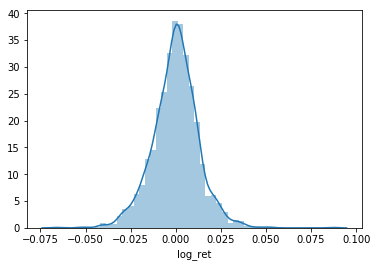

In [81]:
import seaborn as sns
%matplotlib inline
sns.distplot(np.exp(final_df['log_ret'])-1)

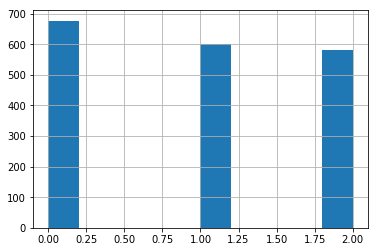

In [82]:
# Labels after bucketing are a bit more uniformly distributed.
final_df['y'].hist()

In [83]:
# Remove log_ret which can lead to look ahead effects
del final_df["log_ret"]

In [84]:
print("shape: {}".format(final_df.shape))


shape: (1858, 231)


In [85]:
train_size = int(final_df.shape[0]*0.9)

### Split into train and test

In [86]:
train, test = final_df.iloc[:train_size], final_df.iloc[train_size:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (1672, 231)
Test shape: (186, 231)


In [87]:
train.to_csv('train_data_oc.csv', index=False)
test.to_csv('test_data_oc.csv', index=False)
train_dummy = pd.read_csv('train_data_oc.csv')
test_dummy = pd.read_csv('test_data_oc.csv')

In [88]:
train.head(3).T

Date,2010-06-02 00:00:00,2010-06-03 00:00:00,2010-06-04 00:00:00
Volume,3.130260e+07,2.459100e+07,2.321810e+07
Adj. Open,3.337378e+01,3.399708e+01,3.407933e+01
Adj. High,3.417700e+01,3.403049e+01,3.412688e+01
Adj. Low,3.327997e+01,3.345668e+01,3.346631e+01
Adj. Close,3.352029e+01,3.392125e+01,3.381459e+01
Adj. Volume,2.191182e+08,1.721370e+08,1.625267e+08
adx_14,3.502739e+01,3.327096e+01,3.155382e+01
adx_28,2.591112e+01,2.540794e+01,2.489877e+01
adx_56,1.673808e+01,1.655924e+01,1.637658e+01
adx_7,3.326602e+01,2.987204e+01,2.728327e+01


### Test if normalization is working as expected.

In [89]:

train_temp = train[['Volume','Adj. Open']].iloc[0:3]
train_temp 

,Volume,Adj. Open
Date,,
2010-06-02,31302600.0,33.373784
2010-06-03,24591000.0,33.997077
2010-06-04,23218100.0,34.079326


In [90]:
mean_temp = train_temp.apply(np.mean,axis=0)
std_temp = train_temp.apply(np.std,axis=0)
(train_temp - mean_temp)/std_temp

,Volume,Adj. Open
Date,,
2010-06-02,1.396296,-1.406156
2010-06-03,-0.503809,0.572526
2010-06-04,-0.892487,0.833630


In [91]:
(train_temp.Volume - np.mean(train_temp.Volume))/np.std(train_temp.Volume)

Date
2010-06-02    1.396296
2010-06-03   -0.503809
2010-06-04   -0.892487
Name: Volume, dtype: float64

In [92]:
mean = train.apply(np.mean,axis=0)
std = train.apply(np.std,axis=0)
norm = (train - mean)/std

In [93]:
norm.describe().T

,count,mean,std,min,25%,50%,75%,max
Volume,1672.0,0.000000e+00,1.000299,-1.117884,-0.723855,-0.306341,0.441655,7.893036
Adj. Open,1672.0,-2.719781e-16,1.000299,-1.742043,-0.874405,-0.116445,0.947338,1.885725
Adj. High,1672.0,3.399726e-16,1.000299,-1.732274,-0.878212,-0.116244,0.947149,1.848446
Adj. Low,1672.0,-2.039836e-16,1.000299,-1.739880,-0.871538,-0.119940,0.942139,1.839194
Adj. Close,1672.0,4.759616e-16,1.000299,-1.732144,-0.870636,-0.112414,0.944924,1.837770
Adj. Volume,1672.0,1.359890e-16,1.000299,-1.380383,-0.751427,-0.237421,0.441186,6.763029
adx_14,1672.0,2.039836e-16,1.000299,-1.694314,-0.727381,-0.189239,0.561600,4.024831
adx_28,1672.0,-1.699863e-16,1.000299,-1.582763,-0.708663,-0.195681,0.525758,3.737684
adx_56,1672.0,2.294815e-16,1.000299,-1.784641,-0.834762,-0.118570,0.847559,2.602304
adx_7,1672.0,9.774212e-17,1.000299,-1.974519,-0.751602,-0.169994,0.562916,3.739946


### Assess distribution and statistics of data

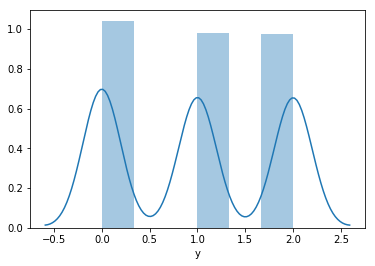

In [94]:
train_y_dummy = train_dummy.pop('y')
test_y_dummy = test_dummy.pop('y')
import seaborn as sns
%matplotlib inline
sns.distplot(train_y_dummy)

### Train RandomForest classifier

In [97]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

rfc = RandomForestClassifier()
rfc_model = rfc.fit(train_dummy, train_y_dummy)
pred = rfc_model.predict(test_dummy)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(test_y_dummy, pred) * 100))


Accuracy for Random Forest Model: 64.52


In [98]:
xgbc = XGBClassifier()
xgbc.fit(train_dummy,  train_y_dummy)
pred = xgbc.predict(test_dummy)
print("Accuracy for XGB Model: %.2f" % (accuracy_score(test_y_dummy, pred) * 100))


Accuracy for XGB Model: 86.02


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
